# Meat Freshness Image Classification

### How can we detect whether meat is fresh or not?

In [27]:
from google.colab import drive 

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Which GPU we are using?

In [28]:
!nvidia-smi

Mon Apr 17 09:58:16 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    53W / 400W |  34173MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Importing the necessary libraries

In [29]:
from numpy import asarray
from PIL import Image
import numpy as np 
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import random
from keras.models import Sequential
from keras import layers
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, GlobalAveragePooling2D, Dense, Dropout
from keras.layers import concatenate
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Definition of image size and path

In [30]:
IMG_WIDTH = 416
IMG_HEIGHT = 416

path_training_set = r'/content/drive/MyDrive/.../train'
path_validation_set = r'/content/drive/MyDrive/.../valid'
fresh_path = r'/content/drive/MyDrive/.../train/fresh'
half_fresh_path = r'/content/drive/MyDrive/.../train/half-fresh'
spoiled_path = r'/content/drive/MyDrive/.../train/spoiled'

# Plotting some example images by category

- fresh

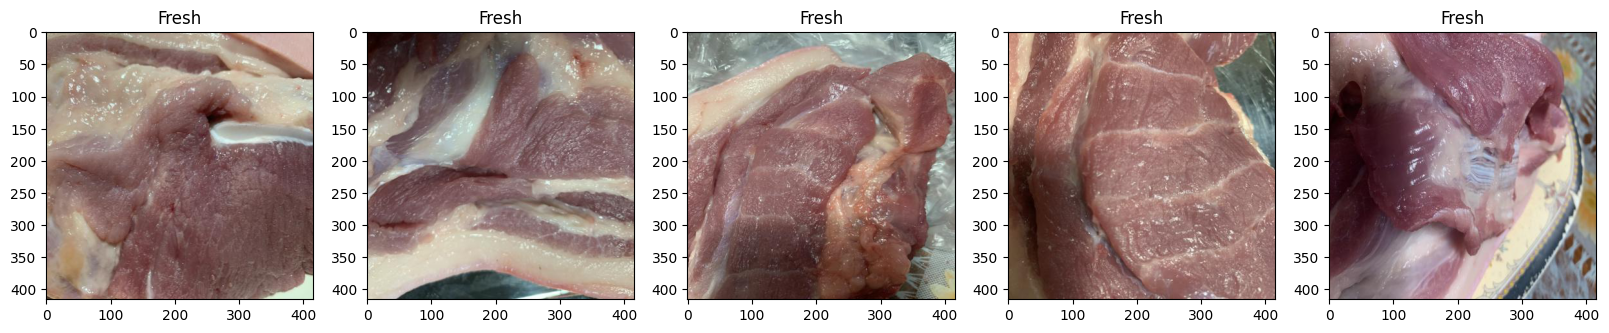

In [31]:
plt.figure(figsize=(20,20))
for i in range(5):
    file = random.choice(os.listdir(fresh_path))
    image_path = os.path.join(fresh_path, file)
    img = mpimg.imread(image_path)
    ax = plt.subplot(1,5,i+1)
    ax.title.set_text("Fresh")
    plt.imshow(img)

- half-fresh

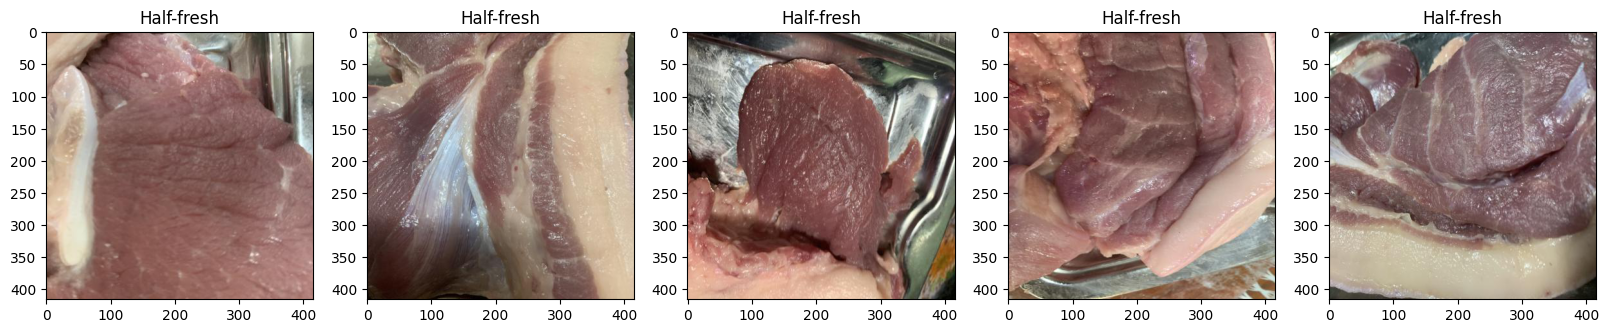

In [32]:
plt.figure(figsize=(20,20))
for i in range(5):
    file = random.choice(os.listdir(half_fresh_path))
    image_path = os.path.join(half_fresh_path, file)
    img = mpimg.imread(image_path)
    ax = plt.subplot(1,5,i+1)
    ax.title.set_text("Half-fresh")
    plt.imshow(img)

- spoiled

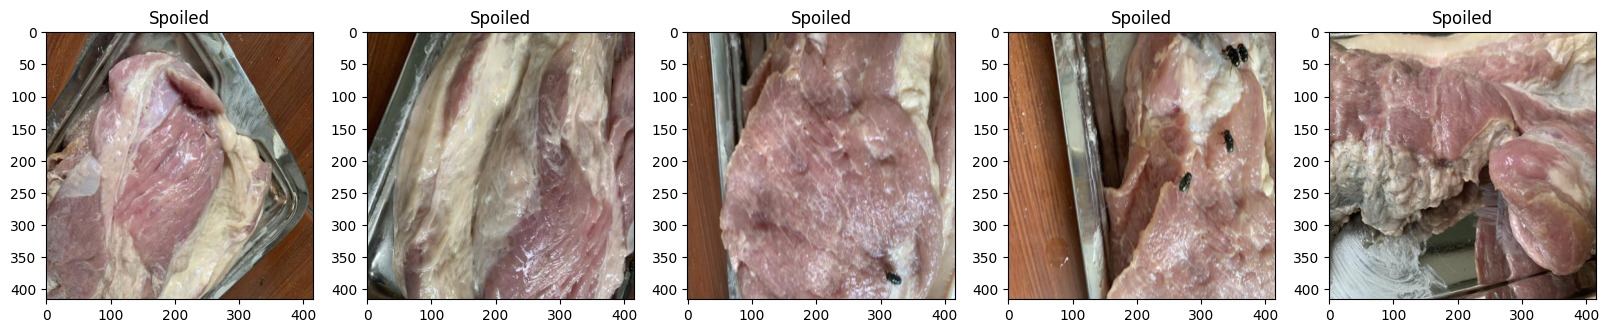

In [33]:
plt.figure(figsize=(20,20))
for i in range(5):
    file = random.choice(os.listdir(spoiled_path))
    image_path = os.path.join(spoiled_path, file)
    img = mpimg.imread(image_path)
    ax = plt.subplot(1,5,i+1)
    ax.title.set_text("Spoiled")
    plt.imshow(img)

# Data loader

In [34]:
def create_dataset(img_folder):
    img_data_array = []
    class_name = []
    for dir1 in os.listdir(img_folder):
        for file in os.listdir(os.path.join(img_folder, dir1)):
            image_path = os.path.join(img_folder, dir1,  file)
            image = cv2.imread( image_path, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH),interpolation = cv2.INTER_AREA)
            image = np.array(image)
            image = image.astype('float32')
            image /= 255 
            img_data_array.append(image)
            class_name.append(dir1)
    return img_data_array, class_name 

# Dataset building

In [35]:
training_img_data, training_class_name = create_dataset(path_training_set)
validation_img_data, validation_class_name = create_dataset(path_validation_set)

In [36]:
target_dict = {k: v for v, k in enumerate(np.unique(training_class_name))}
target_dict

{'fresh': 0, 'half-fresh': 1, 'spoiled': 2}

In [37]:
target_val_training = [target_dict[training_class_name[i]] for i in range(len(training_class_name))]
target_val_validation = [target_dict[validation_class_name[i]] for i in range(len(validation_class_name))]

# NumPy arrays building

In [38]:
X_training = np.array(training_img_data, np.float32)
X_validation = np.array(validation_img_data, np.float32)

In [39]:
y_training = np.array(list(map(int,target_val_training)), np.float32)
y_validation = np.array(list(map(int,target_val_validation)), np.float32)

In [40]:
X_training.shape

(1815, 416, 416, 3)

# Train - test split

In [41]:
X_training, X_test, y_training, y_test = train_test_split(X_training, y_training, test_size=0.2, random_state=17)

# Observation of class occurrences

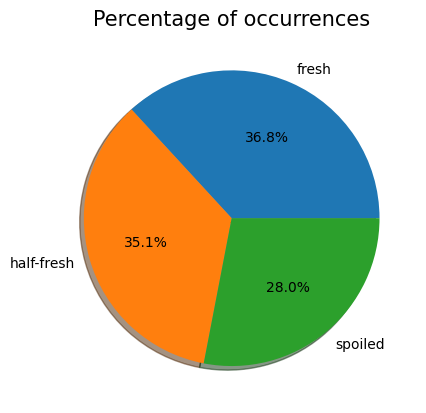

In [42]:
data = []
label=["fresh", "half-fresh", "spoiled"]

for classNum in range(len(label)):
  data.append(np.sum(np.array(y_training) == classNum)) 

plt.title("Percentage of occurrences", fontsize=15)
plt.pie(data, labels=label, shadow=True, autopct='%1.1f%%')
plt.show()

# Class balancing

Through the SMOTE algorithm, classes are rendered perfectly balanced in the training set.

In [43]:
print(len(X_training))
X_training = X_training.reshape(X_training.shape[0], (X_training[0].shape[0]*X_training[0].shape[1]*X_training[0].shape[2]))

1452


In [44]:
train_set_OS = SMOTE()
X_training, y_training = train_set_OS.fit_resample(X_training, y_training)

In [45]:
X_training = X_training.reshape(X_training.shape[0], IMG_WIDTH, IMG_HEIGHT, 3)
print(len(X_training))

1605


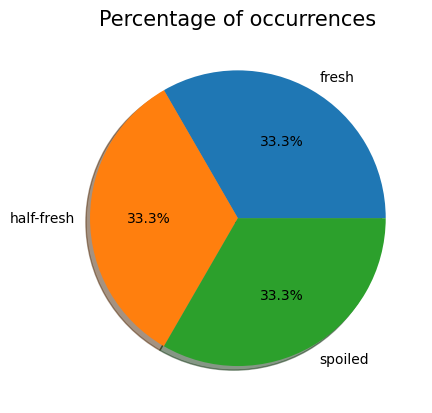

In [46]:
data = []
label=["fresh", "half-fresh", "spoiled"]

for classNum in range(len(label)):
  data.append(np.sum(np.array(y_training) == classNum)) 

plt.title("Percentage of occurrences", fontsize=15)
plt.pie(data, labels=label, shadow=True, autopct='%1.1f%%')
plt.show()

# Artificial-Neural-Network: CNN (Convolutional Neural Network)

In [ ]:
EPOCHS = 50

In [ ]:
kernel_initializer = keras.initializers.glorot_uniform(seed=np.random.randint(20))

model_conv = keras.Sequential(name="Convolutional_Neural_Network")

# Add the preprocessing/augmentation layers
model_conv.add(layers.RandomFlip(mode='horizontal_and_vertical'))

model_conv.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)))
model_conv.add(layers.MaxPooling2D((2, 2)))
model_conv.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_conv.add(layers.MaxPooling2D((2, 2)))
model_conv.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_conv.add(layers.Flatten())
model_conv.add(layers.Dense(64, activation='relu', kernel_initializer=kernel_initializer, kernel_regularizer = keras.regularizers.l2(1/1000)))
model_conv.add(layers.Dense(3, activation='softmax'))

In [ ]:
model_conv.compile(loss = 'sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_cnn = model_conv.fit(X_training, y_training, epochs= EPOCHS, validation_data = (X_validation, y_validation),  batch_size=256)

Epoch 1/50
7/7 [==============================] - 18s 993ms/step - loss: 13.0678 - accuracy: 0.3190 - val_loss: 1.3716 - val_accuracy: 0.2528
Epoch 2/50
7/7 [==============================] - 2s 312ms/step - loss: 1.3644 - accuracy: 0.4075 - val_loss: 1.6458 - val_accuracy: 0.2816
Epoch 3/50
7/7 [==============================] - 2s 312ms/step - loss: 1.4540 - accuracy: 0.3583 - val_loss: 1.3875 - val_accuracy: 0.2550
Epoch 4/50
7/7 [==============================] - 2s 312ms/step - loss: 1.3198 - accuracy: 0.4592 - val_loss: 1.2197 - val_accuracy: 0.6984
Epoch 5/50
7/7 [==============================] - 2s 316ms/step - loss: 1.4531 - accuracy: 0.4916 - val_loss: 1.3461 - val_accuracy: 0.6630
Epoch 6/50
7/7 [==============================] - 2s 312ms/step - loss: 1.2461 - accuracy: 0.5938 - val_loss: 2.6582 - val_accuracy: 0.2749
Epoch 7/50
7/7 [==============================] - 2s 313ms/step - loss: 1.3483 - accuracy: 0.5514 - val_loss: 1.2195 - val_accuracy: 0.5432
Epoch 8/50
7/7 [==

# Test set performance

In [ ]:
score = model_conv.evaluate(X_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

12/12 [==============================] - 1s 36ms/step - loss: 0.4518 - accuracy: 0.9118
Test loss: 0.45181429386138916
Test accuracy: 0.9118457436561584


In [ ]:
y_prob = model_conv.predict(X_test)
y_pred = y_prob.argmax(axis=-1)

12/12 [==============================] - 0s 20ms/step


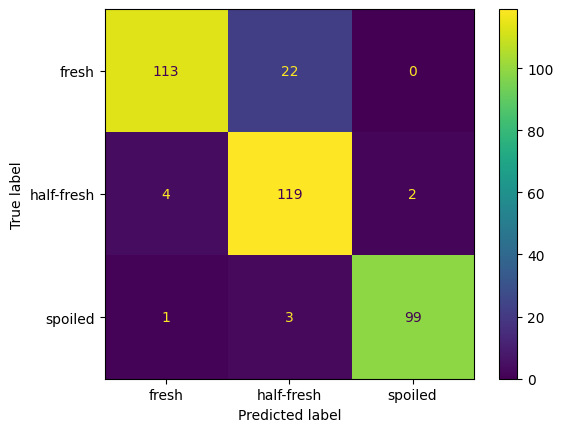

In [ ]:
cm = confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["fresh", "half-fresh", "spoiled"])
disp.plot()
plt.show()